### Imports and config

In [1]:
# Libraries
import os
from importlib import reload
import keras

# Scripts
from helpers import data, runners, utils

In [2]:
# Should be v2.10
!pip show tensorflow 

Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/antrikshdhand/Documents/github/thesis-ml/ml/virt/lib/python3.9/site-packages
Requires: tensorflow-macos
Required-by: 


In [3]:
# Should be v2.10
!pip show keras 

Name: keras
Version: 2.13.1
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /Users/antrikshdhand/Documents/github/thesis-ml/ml/virt/lib/python3.9/site-packages
Requires: 
Required-by: tensorflow-macos


In [4]:
reload(data)
reload(runners)
reload(utils)

<module 'helpers.utils' from '/Users/antrikshdhand/Documents/github/thesis-ml/ml/main/helpers/utils.py'>

In [5]:
# Silence information messages from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Check whether tf is using the GPU
utils.check_gpu_use() 


GPU DETECTED ✓
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## `main`

### Load data

In [6]:
NUM_FOLDS = 10
NUM_EPOCHS = 3
INPUT_SHAPE = (192, 192, 1)
GPU_BATCH_SIZE = 16
DATA_BATCH_SIZE = 16

In [7]:
fold_dfs = data.get_fold_dfs(
    fold_definition_csv='../data/DATASET_CSVS/deepship_5k_seg_3s.csv',
    new_path_to_root='../data/deepship_baseline_detrended_mat/alpha_e0',
    ext='mat',
    unix=True,
    label_encodings={0:'Tanker', 1:'Cargo', 2:'Tug', 3:'Passengership'},
    n_folds=NUM_FOLDS
)
print('Successfully loaded folds.\n')

Successfully loaded folds.



In [8]:
total_samples = 0
for fold_df in fold_dfs:
    total_samples += len(fold_df)
print(total_samples)

53502


### Initialise and configure model

In [9]:
from models import cnn_lstm

cnn_lstm_model = cnn_lstm.get_cnn_lstm(
    input_shape=INPUT_SHAPE,
    input_name='spec',
    num_classes=4,
    verbose=True
)

cnn_lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['acc']
)

Model: "cnn_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spec (InputLayer)           [(None, 192, 192, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 128)     3328      
                                                                 
 batch_normalization (Batch  (None, 192, 192, 128)     512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 192, 192, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 96, 96, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 128)       409

None


In [10]:
# These are kwargs for Model.fit() and Model.evaluate() excluding x and y.
fit_kwargs = {
    'epochs': NUM_EPOCHS,
    'batch_size': GPU_BATCH_SIZE,
    'verbose': 1,
    'callbacks': [cnn_lstm.callback_early_stop(patience=3, restore_best_weights=True)]
}

eval_kwargs = {
    'batch_size': GPU_BATCH_SIZE,
    'verbose': 1
}

### Run k-fold cross val

In [11]:
reload(runners)

# [DBS = GBS = 8] 5 folds, 3 epochs = 100 - 160 min
# [DBS = GBS = 16] 5 folds, 3 epochs = 80 - 100 min
# [DBS = GBS = 16] 5 folds, 3 epochs = 340 min
# [DBS = GBS = 16] 10 folds, 3 epochs = 450 - 500 min

model, histories, evals, metrics = runners.k_fold_cross_validation(
    fold_dfs=fold_dfs,
    model=cnn_lstm_model,
    fit_kwargs=fit_kwargs,
    eval_kwargs=eval_kwargs,
    ext="mat",
    mat_var_name="globalNormalised",
    data_batch_size=DATA_BATCH_SIZE,
    use_cpu=False
)

FOLD 1/10
Epoch 1/3
2716/2716 [==============================] - 708s 260ms/step - loss: 0.7932 - acc: 0.6801 - val_loss: 0.8387 - val_acc: 0.6704
Epoch 2/3
2716/2716 [==============================] - 703s 259ms/step - loss: 0.5044 - acc: 0.8108 - val_loss: 0.8095 - val_acc: 0.6866
Epoch 3/3
1/1 [==============================] - 0s 15ms/step
FOLD 2/10
Epoch 1/3
2666/2666 [==============================] - 685s 257ms/step - loss: 0.2924 - acc: 0.8995 - val_loss: 0.3408 - val_acc: 0.8712
Epoch 2/3
2666/2666 [==============================] - 692s 260ms/step - loss: 0.2009 - acc: 0.9371 - val_loss: 0.4273 - val_acc: 0.8316
Epoch 3/3
1/1 [==============================] - 0s 15ms/step
FOLD 3/10
Epoch 1/3
2527/2527 [==============================] - 679s 268ms/step - loss: 0.1450 - acc: 0.9548 - val_loss: 0.2017 - val_acc: 0.9265
Epoch 2/3
2527/2527 [==============================] - 3111s 1s/step - loss: 0.0805 - acc: 0.9807 - val_loss: 0.2842 - val_acc: 0.8933
Epoch 3/3
1/1 [===========

In [19]:
# model.save('models/saved/cnn_lstm_baseline_12112024/cnn_lstm_baseline_3_epochs.keras')
# model.save('models/saved/cnn_lstm_detrended_12112024/alpha_e0/cnn_lstm_alpha_e0_3_epochs.keras')
# model.save('models/saved/cnn_lstm_detrended_12112024/alpha_e-1/cnn_lstm_alpha_e-1_3_epochs.keras')
model.save('models/saved/cnn_lstm_global_norm_18112024/cnn_lstm_global_norm_3_epochs.keras')

### Calculate metrics

In [23]:
evals

[[0.9532110691070557, 0.6457597017288208],
 [0.936129093170166, 0.6771137118339539],
 [0.6201311349868774, 0.7815315127372742],
 [0.5234190821647644, 0.8197613954544067],
 [0.17534075677394867, 0.9331955909729004],
 [0.1688823401927948, 0.9357829689979553],
 [0.13321606814861298, 0.952531635761261],
 [0.0407722182571888, 0.9871428608894348],
 [0.0212498027831316, 0.9929577708244324],
 [0.04084672033786774, 0.9897727370262146]]

In [24]:
loss, acc = utils.calculate_metrics(evals)
print(f"Average loss: {loss}")
print(f"Average accuracy: {acc}")

Average loss: 0.3613198285922408
Average accuracy: 0.8715549886226654


/var/folders/6d/6rll4yfx64n5s_34fjy87zd80000gn/T/ipykernel_82935/2702590841.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


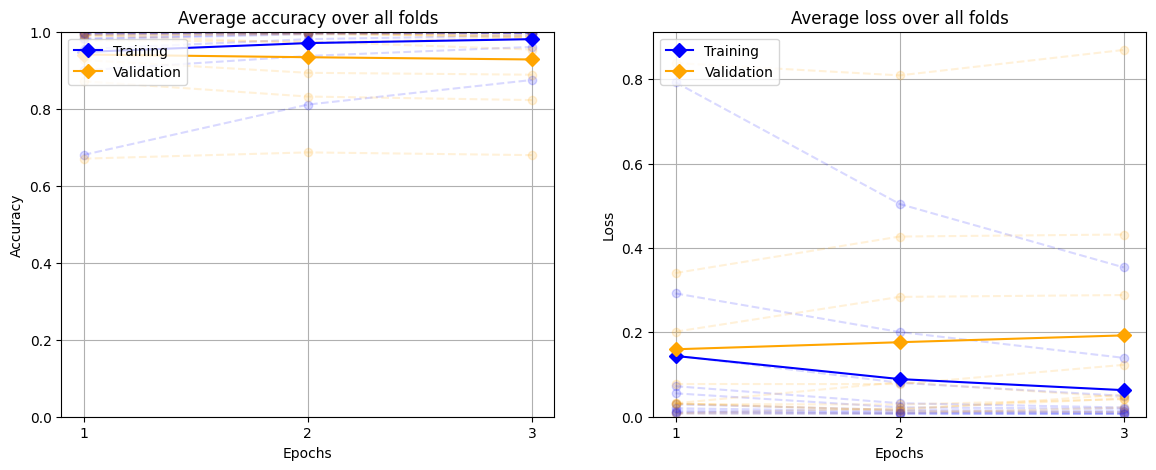

In [25]:
reload(utils)

fig = utils.get_acc_loss_curves_by_epoch(histories, overlay=True)
# fig.savefig('models/saved/cnn_lstm_baseline_12112024/img/3_epochs_by_epoch.pdf')
# fig.savefig('models/saved/cnn_lstm_detrended_12112024/alpha_e-1/img/3_epochs_by_epoch.pdf')
fig.savefig('models/saved/cnn_lstm_global_norm_18112024/img/3_epochs_by_epoch.pdf')
fig.show()

/var/folders/6d/6rll4yfx64n5s_34fjy87zd80000gn/T/ipykernel_82935/365398335.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


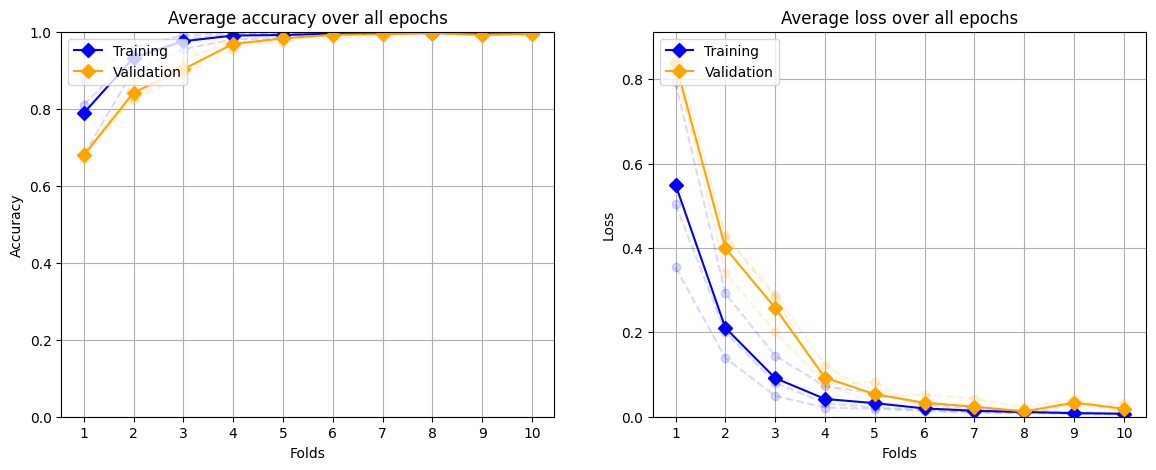

In [26]:
reload(utils)

fig = utils.get_acc_loss_curves_by_fold(histories, overlay=True)
# fig.savefig('models/saved/cnn_lstm_baseline_12112024/img/3_epochs_by_fold.pdf')
# fig.savefig('models/saved/cnn_lstm_detrended_12112024/alpha_e-1/img/3_epochs_by_fold.pdf')
# fig.savefig('models/saved/cnn_lstm_detrended_12112024/alpha_e-2/img/3_epochs_by_fold.pdf')
fig.savefig('models/saved/cnn_lstm_global_norm_18112024/img/3_epochs_by_fold.pdf')
fig.show()

In [27]:
print("Average Precision:", metrics["precision"])
print("Average Recall:", metrics["recall"])
print("Average F1 Score:", metrics["f1_score"])
print("Average Accuracy:", metrics["accuracy"])

Average Precision: 0.8816163894900647
Average Recall: 0.8715549898041853
Average F1 Score: 0.8706760699217568
Average Accuracy: 0.8715549898041853
